In [63]:
#!pip install statsmodels tqdm

In [9]:
import sys
import itertools
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler

# Add utils from /src
sys.path.append("../src")
from neighbourhood.utils.metrics import smape, wmape

In [10]:
df = pd.read_csv('../data/MPS/agg_filtered_boroughs_weekends.csv')
df["TimePeriod"] = pd.to_datetime(df.TimePeriod)

In [11]:
df.head()

,BoroughName,CrimeType,CrimeSubtype,TimePeriod,Value,WorkingDays,Weekends
0,Barking and Dagenham,Arson and Criminal Damage,Arson,2010-04-01,6,20,10
1,Barking and Dagenham,Arson and Criminal Damage,Criminal Damage,2010-04-01,208,20,10
2,Barking and Dagenham,Burglary,Burglary Business and Community,2010-04-01,49,20,10
3,Barking and Dagenham,Burglary,Domestic Burglary,2010-04-01,118,20,10
4,Barking and Dagenham,Drug Offences,Drug Trafficking,2010-04-01,9,20,10


# Модель экспоненциального сглаживания

* Берем из датасета только график (дата и значение)
* Получаем все виды районов и преступлений
* В цикле проходим по всем комбинациям районов и преступлений
* Делаем прогноз с помощью модели [Холта-Винтера](https://otexts.com/fpp2/holt-winters.html)
* Сохраняем прогноз на последний год (для теста), а также прогноз на следующие 12 месяцев (для использования)
* Считаем метрику MAPE на данных за последние 12 месяцев

In [13]:
test_interval = 12
df_timeseries = df[['BoroughName', 'CrimeType', 'CrimeSubtype', 'Value', 'TimePeriod']]
df_timeseries = df_timeseries.sort_values('TimePeriod')


In [14]:
%%time
iter_boroughs = []
iter_crime_types = []
iter_crime_subtypes = []
iter_test_real = []
iter_test_predict = []
for (borough, crime_subtype, crimetype), group in tqdm(df_timeseries.groupby(['BoroughName', 'CrimeSubtype', 'CrimeType'])):
    
    train = group.iloc[:-test_interval, ]["Value"].values
    test = group.iloc[-test_interval:, ]["Value"].values
    try:
        model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=test_interval)
        model_fit = model.fit()
        pred = model_fit.predict(start=len(train), end=len(train) + test_interval-1)
    except Exception as e:
        print(f"Cannot calculate {borough} {crime_subtype}")
        print(f"    ! {e}")
        predictions = np.full(test_interval, train[-1])

    iter_boroughs.append(borough)
    iter_crime_types.append(crimetype)
    iter_crime_subtypes.append(crime_subtype)
    iter_test_real.extend(test)
    iter_test_predict.extend(pred)
    

  2%|██▋                                                                                                                                                                       | 27/1697 [00:01<01:06, 25.12it/s]

Cannot calculate Barking and Dagenham Offender Management Act
    ! Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.
Cannot calculate Barking and Dagenham Other Knife Offences
    ! Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


  6%|██████████▉                                                                                                                                                              | 110/1697 [00:05<01:10, 22.41it/s]

Cannot calculate Bexley Absconding from Lawful Custody
    ! Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


  8%|█████████████▏                                                                                                                                                           | 132/1697 [00:06<01:06, 23.40it/s]

Cannot calculate Bexley Offender Management Act
    ! Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


 11%|██████████████████▎                                                                                                                                                      | 184/1697 [00:09<01:10, 21.54it/s]

Cannot calculate Brent Offender Management Act
    ! Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


 17%|████████████████████████████▊                                                                                                                                            | 289/1697 [00:14<01:08, 20.65it/s]

Cannot calculate Camden Offender Management Act
    ! Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


 20%|██████████████████████████████████▍                                                                                                                                      | 346/1697 [00:17<01:04, 20.90it/s]

Cannot calculate Croydon Other Knife Offences
    ! Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


 33%|███████████████████████████████████████████████████████▏                                                                                                                 | 554/1697 [00:29<01:23, 13.76it/s]

Cannot calculate Hackney Offender Management Act
    ! Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


 39%|██████████████████████████████████████████████████████████████████▏                                                                                                      | 664/1697 [00:36<00:53, 19.36it/s]

Cannot calculate Haringey Other Knife Offences
    ! Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


 44%|██████████████████████████████████████████████████████████████████████████▉                                                                                              | 753/1697 [00:42<00:47, 20.08it/s]

Cannot calculate Havering Concealing an Infant Death Close to Birth
    ! Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                          | 791/1697 [00:44<00:47, 19.03it/s]

Cannot calculate Havering Soliciting for Prostitution
    ! Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1012/1697 [00:57<00:33, 20.30it/s]

Cannot calculate Kingston upon Thames Aiding Suicide
    ! Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.
Cannot calculate Kingston upon Thames Bigamy
    ! Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 1279/1697 [01:11<00:19, 21.10it/s]

Cannot calculate Redbridge Aiding Suicide
    ! Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1434/1697 [01:20<00:14, 18.02it/s]

Cannot calculate Sutton Aiding Suicide
    ! Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1509/1697 [01:24<00:09, 18.98it/s]

Cannot calculate Tower Hamlets Offender Management Act
    ! Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1540/1697 [01:26<00:07, 20.54it/s]

Cannot calculate Waltham Forest Aiding Suicide
    ! Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1563/1697 [01:27<00:08, 16.47it/s]

Cannot calculate Waltham Forest Other Knife Offences
    ! Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1638/1697 [01:32<00:03, 18.82it/s]

Cannot calculate Wandsworth Soliciting for Prostitution
    ! Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1697/1697 [01:37<00:00, 17.47it/s]

CPU times: user 1min 38s, sys: 769 ms, total: 1min 39s
Wall time: 1min 37s


## Сколько типов преступлений по borough

In [15]:
df.groupby("CrimeSubtype")["BoroughName"].nunique()

CrimeSubtype
Absconding from Lawful Custody                        32
Aggravated Vehicle Taking                             32
Aiding Suicide                                         6
Arson                                                 32
Bail Offences                                         32
Bicycle Theft                                         32
Bigamy                                                30
Burglary Business and Community                       32
Concealing an Infant Death Close to Birth              5
Criminal Damage                                       32
Dangerous Driving                                     32
Disclosure, Obstruction, False or Misleading State    32
Domestic Burglary                                     32
Drug Trafficking                                      32
Exploitation of Prostitution                          32
Forgery or Use of Drug Prescription                   32
Fraud or Forgery Associated with Driver Records       32
Going Equipped for

# Смотрим предсказания на 12 месяцев

Смотирм ошибку RMSE и MAE, SMAPE, WMAPE

In [16]:
print(f"Кобминаций районов-типов преступлений {len(iter_boroughs)}, тестоовых значений {len(iter_test_real)}, предсказаний {len(iter_test_predict)}")


Кобминаций районов-типов преступлений 1697, тестоовых значений 20364, предсказаний 20364


In [17]:
df_pred_test = pd.DataFrame({
    "CrimeType": list(itertools.chain.from_iterable([itertools.repeat(x, 12) for x in iter_crime_types])),
    "CrimeSubtype": list(itertools.chain.from_iterable([itertools.repeat(x, 12) for x in iter_crime_subtypes])),
    "BoroughName": list(itertools.chain.from_iterable([itertools.repeat(x, 12) for x in iter_boroughs])),
    "real": iter_test_real,
    "pred": iter_test_predict
})

In [18]:
df_pred_test['diff'] = np.abs(df_pred_test.pred - df_pred_test.real)

In [19]:
df_pred_test.sort_values('diff', ascending=False)[:30]

,CrimeType,CrimeSubtype,BoroughName,real,pred,diff
20271,Theft,Theft from Person,Westminster,2814,1312.506223,1501.493777
20270,Theft,Theft from Person,Westminster,2355,1170.503353,1184.496647
20272,Theft,Theft from Person,Westminster,2296,1132.756328,1163.243672
20273,Theft,Theft from Person,Westminster,2036,1187.578851,848.421149
20275,Theft,Theft from Person,Westminster,1893,1045.560416,847.439584
20066,Theft,Other Theft,Westminster,2604,1790.111216,813.888784
20269,Theft,Theft from Person,Westminster,1964,1165.034987,798.965013
20274,Theft,Theft from Person,Westminster,1935,1172.117808,762.882192
20276,Theft,Theft from Person,Westminster,1771,1068.796475,702.203525
20067,Theft,Other Theft,Westminster,2652,1961.169207,690.830793


In [23]:
print(f"RMSE {np.sqrt(mean_squared_error(iter_test_real, iter_test_predict))}")
print(f"MAE {mean_absolute_error(iter_test_real, iter_test_predict)}")
print(f"SMAPE {smape(np.array(iter_test_real), np.array(iter_test_predict))}")
print(f"WMAPE {wmape(np.array(iter_test_real), np.array(iter_test_predict))}")


RMSE 28.60708033963433
MAE 7.8572516454101375
SMAPE 38.69230045399836
WMAPE 17.78634524504161


# Графики

RMSE 1.1023605728335246


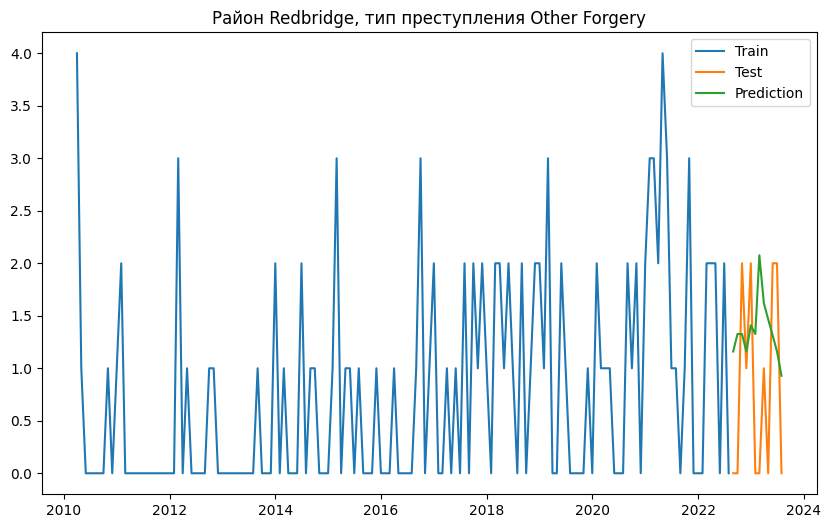

In [12]:
random_borough = np.random.choice(df['BoroughName'])
random_crime = np.random.choice(df['CrimeSubtype'])

filtered_df = df[(df['BoroughName'] == random_borough) & (df['CrimeSubtype'] == random_crime)]
filtered_df.set_index('TimePeriod', inplace=True)

train, test = filtered_df.iloc[:int(len(filtered_df)-12), :], filtered_df.iloc[int(len(filtered_df)-12):, :]

pred =  df_pred_test[(df_pred_test['BoroughName'] == random_borough) & (df_pred_test['CrimeSubtype'] == random_crime)]
print(f"RMSE {np.sqrt(mean_squared_error(test.Value, pred.pred))}")

plt.figure(figsize=(10,6))
plt.plot(train.index, train.Value, label='Train')
plt.plot(test.index, test.Value, label='Test')
plt.plot(test.index, pred.pred, label='Prediction')
plt.legend(loc='best')
plt.title(f"Район {random_borough}, тип преступления {random_crime}");
plt.show();


# Строим предсказания на сделующие 12 месяцев

In [15]:
%%time
iter_boroughs = []
iter_crime_types = []
iter_crime_subtypes = []
iter_new_predict = []
for (borough, crime_subtype, crime_type), group in tqdm(df_timeseries.groupby(['BoroughName', 'CrimeSubtype', 'CrimeType'])):
    train = group["Value"].values
    try:
        model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=test_interval)
        model_fit = model.fit()
        predictions = model_fit.predict(start=len(train), end=len(train) + test_interval-1)
    except Exception as e:
        print(f"Cannot calculate {borough} {crime_subtype}")
        print(f"    ! {e}")
        predictions = np.full(test_interval, train[-1])

    iter_boroughs.append(borough)
    iter_crime_types.append(crime_type)
    iter_crime_subtypes.append(crime_subtype)
    iter_new_predict.extend(predictions)
    

100%|███████████████████████████████████████████████████████████████████████████████| 1697/1697 [02:48<00:00, 10.07it/s]

CPU times: user 2min 49s, sys: 1.81 s, total: 2min 51s
Wall time: 2min 48s


In [16]:
print(f"Кобминаций районов-типов преступлений {len(iter_boroughs)}, предсказаний {len(iter_new_predict)}")


Кобминаций районов-типов преступлений 1697, предсказаний 20364


In [17]:
last_date = df.TimePeriod.max()
months = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='M')

In [47]:
df_pred = pd.DataFrame({
    "TimePeriod": list(itertools.chain.from_iterable([months for x in iter_boroughs])),
    "CrimeType": list(itertools.chain.from_iterable([itertools.repeat(x, 12) for x in iter_crime_types])),
    "CrimeSubtype": list(itertools.chain.from_iterable([itertools.repeat(x, 12) for x in iter_crime_subtypes])),
    "BoroughName": list(itertools.chain.from_iterable([itertools.repeat(x, 12) for x in iter_boroughs])),
    "Value": iter_new_predict
})

In [48]:
df_pred

,TimePeriod,CrimeType,CrimeSubtype,BoroughName,Value
0,2023-09-30,Miscellaneous Crimes Against Society,Absconding from Lawful Custody,Barking and Dagenham,-0.004100
1,2023-10-31,Miscellaneous Crimes Against Society,Absconding from Lawful Custody,Barking and Dagenham,-0.004102
2,2023-11-30,Miscellaneous Crimes Against Society,Absconding from Lawful Custody,Barking and Dagenham,-0.004111
3,2023-12-31,Miscellaneous Crimes Against Society,Absconding from Lawful Custody,Barking and Dagenham,-0.004115
4,2024-01-31,Miscellaneous Crimes Against Society,Absconding from Lawful Custody,Barking and Dagenham,-0.004120
...,...,...,...,...,...
20359,2024-04-30,Miscellaneous Crimes Against Society,Wildlife Crime,Westminster,-0.027706
20360,2024-05-31,Miscellaneous Crimes Against Society,Wildlife Crime,Westminster,-0.022163
20361,2024-06-30,Miscellaneous Crimes Against Society,Wildlife Crime,Westminster,0.061208
20362,2024-07-31,Miscellaneous Crimes Against Society,Wildlife Crime,Westminster,0.144578


# Определение рейтинга района

In [18]:
df_pivot = (
    pd.pivot(
        df_pred, 
        index=["BoroughName", "TimePeriod"], 
        columns=["CrimeSubtype"], 
        values=["pred"]
    )
    .fillna(0)
)

In [19]:
rating_raw = df_pivot.apply(lambda row: np.mean(row), axis=1)

In [20]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(rating_raw.values.reshape(-1,1))
rating_scaled = pd.Series(scaled.reshape(-1,), index = rating_raw.index)

In [21]:
rating_scaled = rating_scaled.reset_index()

In [22]:
rating_scaled

,BoroughName,TimePeriod,0
0,Barking and Dagenham,2023-09-30,0.143309
1,Barking and Dagenham,2023-10-31,0.154357
2,Barking and Dagenham,2023-11-30,0.156077
3,Barking and Dagenham,2023-12-31,0.137052
4,Barking and Dagenham,2024-01-31,0.146145
...,...,...,...
379,Westminster,2024-04-30,0.869833
380,Westminster,2024-05-31,0.917375
381,Westminster,2024-06-30,0.926983
382,Westminster,2024-07-31,1.000000


In [23]:
rating_scaled.columns = ["BoroughName", "TimePeriod", "pred"]

In [24]:
rating_scaled["CrimeSubtype"] = "Rating"

In [12]:
df_result = pd.concat([df_pred, rating_scaled])

# Combine last year and prediction

In [49]:
current_date = datetime.now()
last_year_start = datetime(current_date.year-1, current_date.month, 1)

In [50]:
df_last_year = df_timeseries[df_timeseries.TimePeriod >= last_year_start ]

In [51]:
df_result = pd.concat([df_last_year, df_pred])

In [52]:
df_result

,BoroughName,CrimeType,CrimeSubtype,Value,TimePeriod
252463,Lewisham,Miscellaneous Crimes Against Society,Possession of False Documents,0.000000,2022-11-01
252464,Lewisham,Miscellaneous Crimes Against Society,Profitting From or Concealing Proceeds of Crime,0.000000,2022-11-01
252465,Lewisham,Miscellaneous Crimes Against Society,Threat or Possession With Intent to Commit Cri...,9.000000,2022-11-01
252470,Lewisham,Possession of Weapons,Possession of Other Weapon,9.000000,2022-11-01
252467,Lewisham,Possession of Weapons,Possession of Article with Blade or Point,10.000000,2022-11-01
...,...,...,...,...,...
20359,Westminster,Miscellaneous Crimes Against Society,Wildlife Crime,-0.027706,2024-04-30
20360,Westminster,Miscellaneous Crimes Against Society,Wildlife Crime,-0.022163,2024-05-31
20361,Westminster,Miscellaneous Crimes Against Society,Wildlife Crime,0.061208,2024-06-30
20362,Westminster,Miscellaneous Crimes Against Society,Wildlife Crime,0.144578,2024-07-31


In [53]:
df_result.columns = ["borough", "crime_type", "crime_subtype", "value", "month"]

In [54]:
df_result.to_csv("../data/predictions/roman_3_predictions.csv", index=False)